 # Job Role Prediction: Advanced Model Training Notebook
 
 This notebook walks through an enhanced process of training a machine learning model to predict a job role from skills. We will incorporate hyperparameter tuning to achieve the highest possible accuracy.
 
### Steps:
 1.  **Load Data**: Import the dataset using pandas.
 2.  **Prepare Data**: Separate features (X) and the target variable (y).
 3.  **Split Data**: Divide the data into training and testing sets.
 4.  **Hyperparameter Tuning**: Use `GridSearchCV` to find the best parameters for our `RandomForestClassifier`.
 5.  **Train Final Model**: Train a new model using the optimal parameters found.
 6.  **Evaluate Model**: Check the final model's accuracy and view its feature importance.
 7.  **Save Model**: Export the optimized model and the feature list.



## 1. Import Necessary Libraries


In [27]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## 2. Load and Inspect the Dataset
 
 We'll load the `job_skills_dataset.csv` file into a pandas DataFrame and take a quick look at its structure.


In [28]:
import os
print("Current working directory:", os.getcwd())


Current working directory: d:\Github all\project\1_job_role_suggestor_ml\model_training


In [29]:
import os
import pandas as pd
from IPython.display import display

# Use raw string to avoid escape sequence issues
DATASET_PATH = r'..\dataset\job_skills_80_roles_weighted.csv'

if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset not found at '{DATASET_PATH}'.")
    print("Please make sure 'job_skills_dataset.csv' is in the 'dataset' folder.")
else:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nJob Role Distribution:")
    display(df['Job_Role'].value_counts())


Dataset loaded successfully.
Dataset shape: (50000, 141)

First 5 rows:


,Python,Java,JavaScript,C#,Go,TypeScript,SQL,NoSQL,PostgreSQL,MongoDB,...,Problem-Solving,Time Management,Adaptability,Critical Thinking,Creativity,Negotiation,Empathy,Patience,Attention to Detail,Job_Role
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.82,0.00,0.21,0.00,Real Estate Agent
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.28,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.15,Network Engineer
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.00,0.27,0.00,0.00,Physician
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.12,0.20,0.0,0.0,0.66,0.00,0.00,0.00,Event Planner
4,0.0,0.0,1.0,0.0,0.0,0.0,0.88,0.0,0.0,0.0,...,0.00,0.24,0.11,0.0,0.0,0.00,0.00,0.00,0.00,Full-Stack Developer



Job Role Distribution:


Job_Role
Data Analyst                       703
AI Ethics Specialist               696
Cybersecurity Analyst              682
Marketing Manager                  672
Blockchain Developer               670
                                  ... 
Pilot                              593
Translator                         593
Site Reliability Engineer (SRE)    592
Software Engineer                  588
Lawyer                             587
Name: count, Length: 80, dtype: int64

## 3. Prepare Data for Training
 
 We need to separate our data into features (the skills) and the target (the job role).
 
 * **X (Features)**: All columns except for 'Job_Role'.
 * **y (Target)**: The 'Job_Role' column.

In [30]:
# --- Define Features (X) and Target (y) ---
X = df.drop('Job_Role', axis=1)
y = df['Job_Role']

# Store the feature names (skill columns) for later use
feature_list = list(X.columns)

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nNumber of features: {len(feature_list)}")
print("First 5 skills in feature list:", feature_list[:5])


Features (X) shape: (50000, 140)
Target (y) shape: (50000,)

Number of features: 140
First 5 skills in feature list: ['Python', 'Java', 'JavaScript', 'C#', 'Go']


 ## 4. Split Data into Training and Testing Sets
 
 We'll split the data to train the model on one part and test its performance on another, unseen part. We use `stratify=y` to ensure that the proportion of each job role is the same in both the training and testing sets.


In [31]:
# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% of data will be used for testing
    random_state=42, # for reproducibility
    stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 40000 samples
Testing set size: 10000 samples


## 5. Hyperparameter Tuning with GridSearchCV
 
 Instead of guessing the best parameters for our model, we'll use `GridSearchCV` to systematically test a combination of parameters and find the ones that give the highest accuracy. This is a key step for maximizing performance.
 
 **Note**: This step can be computationally intensive and may take a few minutes to run.


In [32]:
# --- Define the parameter grid to search ---
# These are some of the most important parameters for a RandomForest.
param_grid = {
    'n_estimators': [100, 200],         # Number of trees in the forest
    'max_depth': [10, 20, None],        # Maximum depth of the tree
    'min_samples_split': [2, 5],        # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2],         # Minimum number of samples required at each leaf node
    'criterion': ['gini', 'entropy']    # Function to measure the quality of a split
}


In [40]:
# --- Initialize the GridSearchCV object ---
# cv=3 means we'll use 3-fold cross-validation.
# n_jobs=-1 means we'll use all available CPU cores to speed up the process.
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=2  # This will print progress updates
)

print("Starting hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)
print("Hyperparameter tuning complete.")

Starting hyperparameter tuning with GridSearchCV...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Hyperparameter tuning complete.


In [41]:
# --- Get the best parameters ---
best_params = grid_search.best_params_
print(f"\nBest parameters found: {best_params}")


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## 6. Train the Final Model with Optimal Parameters
 
 Now we'll create a new `RandomForestClassifier` using the best parameters we just found and train it on the entire training set.


In [42]:
# --- Initialize and Train the Final Model ---
print("Training the final model with the best parameters...")

# Initialize the model with the best parameters found by GridSearchCV
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)

# Train the model on the entire training data
final_model.fit(X_train, y_train)

print("Final model training complete.")

Training the final model with the best parameters...
Final model training complete.


## 7. Evaluate the Optimized Model's Performance
 
 Let's see how our new, optimized model performs on the unseen test data.


In [43]:
# --- Make predictions on the test data ---
y_pred = final_model.predict(X_test)

# --- Calculate accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Model Accuracy: {accuracy:.4f}")

# --- Display the Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Optimized Model Accuracy: 0.9625

Classification Report:
                                 precision    recall  f1-score   support

           AI Ethics Specialist       1.00      1.00      1.00       139
                     Accountant       1.00      1.00      1.00       121
                        Actuary       1.00      1.00      1.00       129
                      Architect       1.00      1.00      1.00       127
                         Artist       1.00      1.00      1.00       133
              Backend Developer       1.00      1.00      1.00       120
                      Biologist       1.00      1.00      1.00       123
           Blockchain Developer       1.00      1.00      1.00       134
                           Chef       1.00      1.00      1.00       125
                        Chemist       1.00      1.00      1.00       120
                 Civil Engineer       1.00      1.00      1.00       121
                 Cloud Engineer       1.00      1.00      1.00    

c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### Confusion Matrix
 Let's visualize the performance of our optimized model.


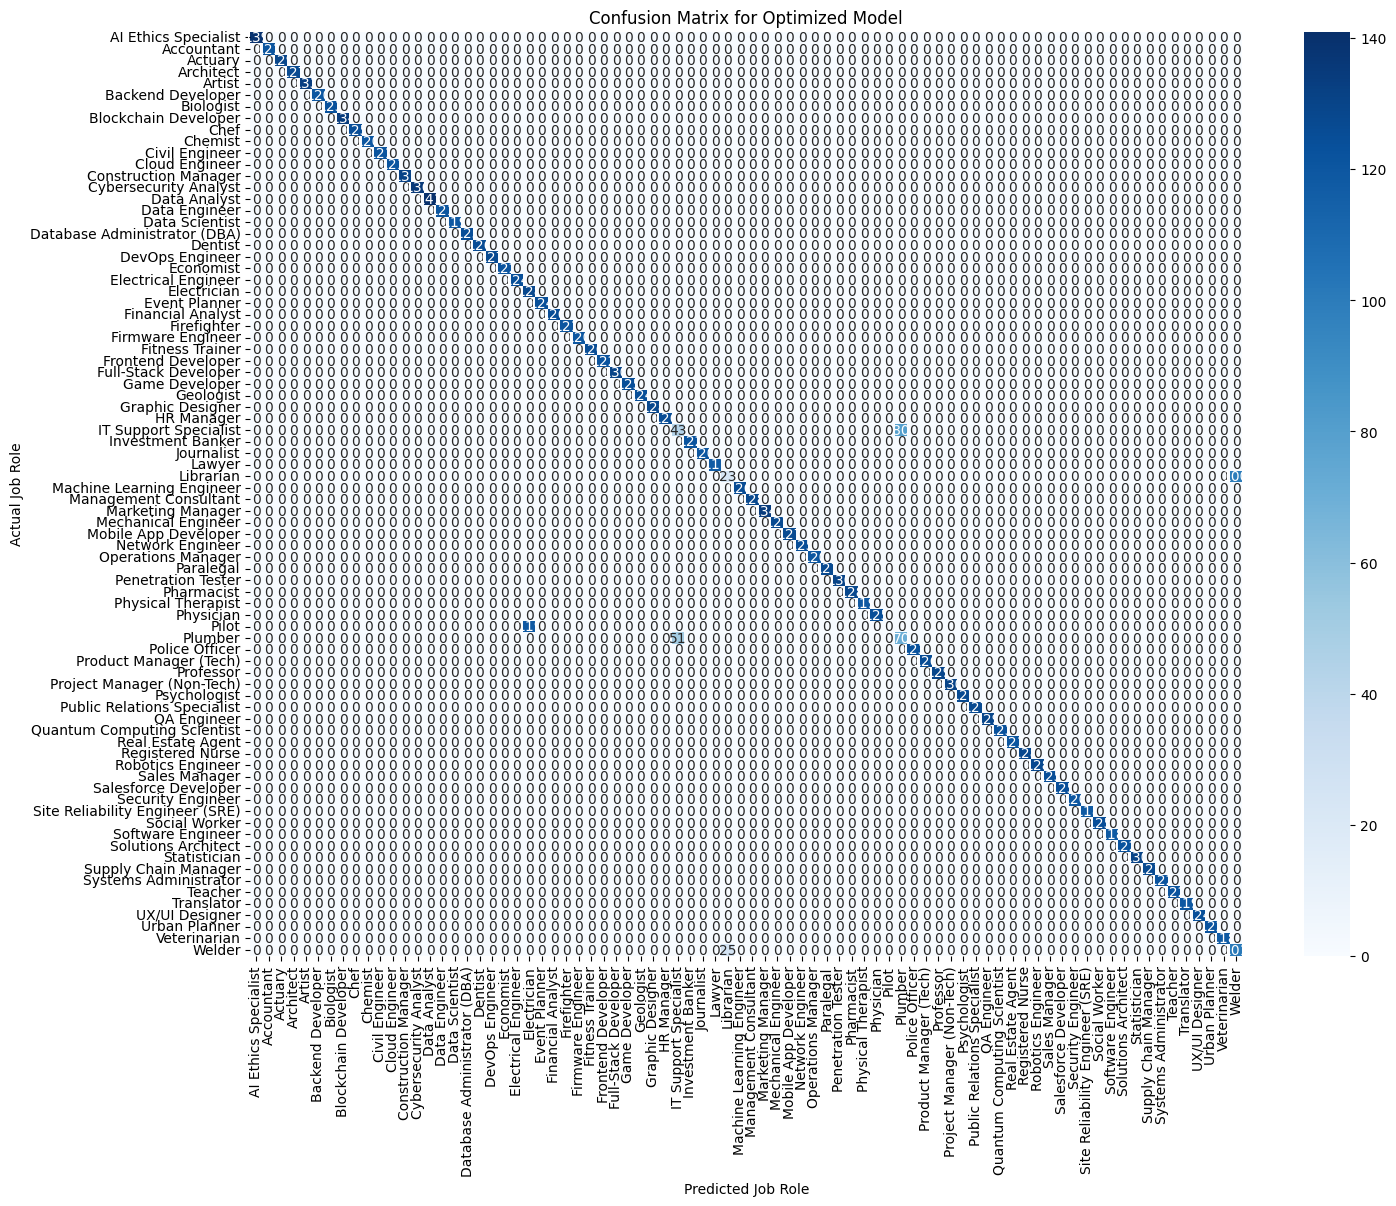

In [44]:
# --- Visualize the Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.title('Confusion Matrix for Optimized Model')
plt.ylabel('Actual Job Role')
plt.xlabel('Predicted Job Role')
plt.show()


### Feature Importance
Let's look at the top 20 skills that the model found most important for making its predictions.


C:\Users\Hp\AppData\Local\Temp\ipykernel_35540\1951319645.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


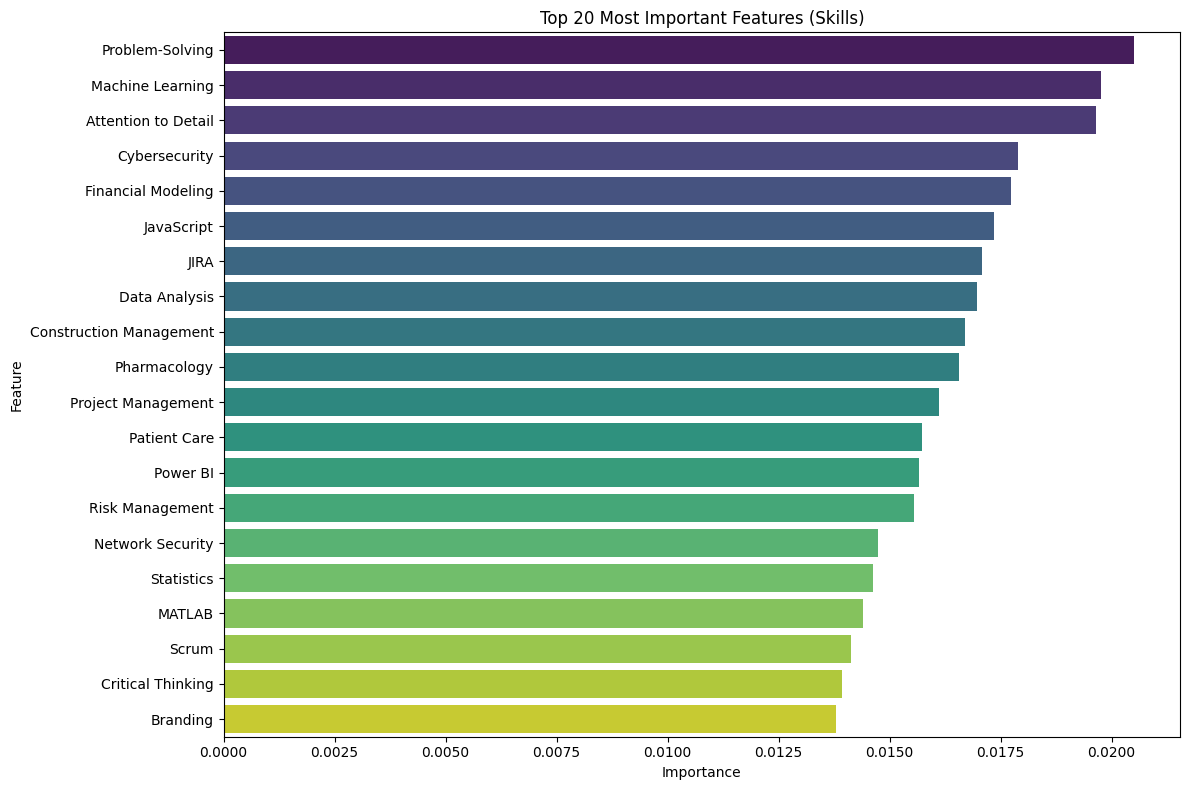

In [45]:
# --- Visualize Feature Importance ---
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_list, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Most Important Features (Skills)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 8. Save the Trained Model and Feature List
 
 Finally, we'll save the optimized model and the list of feature names. These files will be loaded by our Flask API to make live predictions.


In [46]:
# --- Create a directory to save the model ---
MODEL_DIR = 'saved_model'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# --- Define file paths ---
MODEL_PATH = os.path.join(MODEL_DIR, 'job_role_predictor.joblib')
FEATURES_PATH = os.path.join(MODEL_DIR, 'feature_list.joblib')

# --- Save the model and feature list ---
joblib.dump(final_model, MODEL_PATH)
joblib.dump(feature_list, FEATURES_PATH)

print(f"Optimized model saved to: {MODEL_PATH}")
print(f"Feature list saved to: {FEATURES_PATH}")
print("\nSetup complete! The optimized model is ready to be used by the API.")


Optimized model saved to: saved_model\job_role_predictor.joblib
Feature list saved to: saved_model\feature_list.joblib

Setup complete! The optimized model is ready to be used by the API.
